# CIFAR-10 Dataset:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

CIFAR-10 dataset contains images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="images/1.jpg" style="width:50%">

In [31]:
import tensorflow as tf
import keras
import os
import math
import pickle
import cPickle
import cv2
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam

print(tf.__version__)
print(keras.__version__)

1.11.0
2.2.4


# Load dataset

### 1. Download the dataset from [here](http://www.cs.toronto.edu/~kriz/cifar.html) and read in python 

X Shape: (60000, 32, 32, 3)
Y Shape: (60000, 1)

 Sample Image:
: AxesImage(54,36;334.8x217.44)


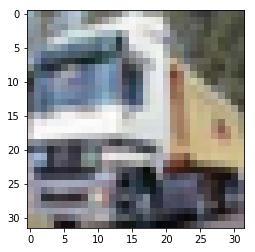

In [2]:
data = []
labels = []

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

for f in os.listdir("cifar-10-batches-py/"):
    if "_batch" in f:
        data.extend(unpickle("cifar-10-batches-py/" + str(f))['data'])
        labels.extend(unpickle("cifar-10-batches-py/" + str(f))['labels'])
        
X_data = np.stack(data, axis=0)  ## This read flattern image (60000, 3072)
X_data = np.reshape(X_data, (60000, 32, 32, 3), order='F') # Convert into RGB (60000, 32, 32, 3)
X_data = np.transpose(X_data,(0,2,1,3)) # Images are rotated, so take a transpose

Y_data = np.stack(labels, axis = 0)
Y_data = np.reshape(Y_data, (60000,1))

print "X Shape:", X_data.shape
print "Y Shape:", Y_data.shape

print "\n Sample Image:\n:", plt.imshow(X_data[1])

### 2. Load the dataset using keras .load_data() function

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

('Train samples:', (50000, 32, 32, 3), (50000, 1))
('Test samples:', (10000, 32, 32, 3), (10000, 1))


In [5]:
nclasses = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


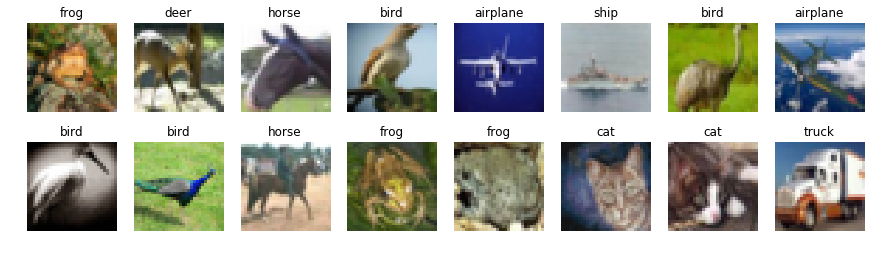

In [6]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

We need to normalize inputs like this: 
$$x_{norm} = \frac{x}{255} - 0.5$$

In [7]:
# normalize inputs
x_train_norm = (x_train.astype(float)/255) - 0.5
x_test_norm = (x_test.astype(float)/255) - 0.5

# One-Hot encoding for output
y_train_one_hot = np.eye(nclasses)[y_train[:,0]]
y_test_one_hot = np.eye(nclasses)[y_test[:,0]]

print "X shape:", x_train_norm.shape 
print "Y shape:", y_train_one_hot.shape

X shape: (50000, 32, 32, 3)
Y shape: (50000, 10)


# Define CNN architecture

In [8]:
# import necessary building blocks

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

Model:

Cov2D layer with 16, 3 X 3 filters ---> LeakyReLu ---> Conv2D layer with 32, 3 X 3 filters ---> LeakyReLu ---> MaxPooling2D 2 X 2 ---> Dropout ---> Conv2D layer with 128, 3 X 3 ---> LeakyReLu ---> Conv2D layer with 128, 3 X 3 ---> LeakyReLu ---> MaxPooling2D 2 X 2 ---> Dropout ---> Flatten (Dense layer) 1024 ---> LeakyReLu ---> Dropout ---> Dense layer 10 ---> SoftMax ---> Output 



Input: __(None, 32, 32, 3)__ 
Output: __(None, 10)__  (probabilities for all classes)
. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and dense layers):
```python
model.add(LeakyReLU(0.1))
```

Add a dense layer with __256__ neurons and a second dense layer with __10__ neurons for classes. Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between dense layers (__0.5__).

In [9]:
def cnn_model():

    model = Sequential()
    
    #Conv 1
    model.add(Conv2D(16, kernel_size=(3, 3),input_shape=(32, 32, 3), padding="same", strides = (1, 1), name = "conv1"))
    model.add(LeakyReLU(0.1))
    
    #Conv 2
    model.add(Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding="same", name = "conv2"))
    model.add(LeakyReLU(0.1))
    
    #MaxPooling 1
    model.add(MaxPooling2D(pool_size=(2, 2), name = "max_pool_1"))
    model.add(Dropout(0.25, noise_shape=None, seed=0))

    #Conv 3
    model.add(Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding="same", name = "conv3"))
    model.add(LeakyReLU(0.1))
    
    #Conv 4
    model.add(Conv2D(64, (3, 3), strides = (1, 1), padding="same", name = 'conv4'))  
    model.add(LeakyReLU(0.1))
    
    #MaxPooling 2
    model.add(MaxPooling2D(pool_size=(2, 2), name = "max_pool_2"))
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    #Flatten
    model.add(Flatten())    
    
    #Fully Connected
    model.add(Dense(256, name='fc1'))
    model.add(Dropout(0.5, noise_shape=None, seed=0))
    
    #Fully Connected
    model.add(Dense(nclasses))  #dense layer with number of classes   
    model.add(Activation("softmax"))  #apply softmac to get probabilities

    return model

K.clear_session()
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        9248      
__________

In [19]:
## Plot Model Accuracy

def plot_fig(i, history, epochs):
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['val_acc'],label='validation')
    plt.plot(range(1,epochs+1),history.history['acc'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
    #plt.ylim([0,1])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
    plt.close(fig)

# Train model

The Goal here is optimize the CNN model

In [15]:
%%time

model = cnn_model()

def step_decay(epoch):
    initial_lrate = 0.005
    lrate = initial_lrate * 0.9 ** epoch
    return lrate

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('Learning rate:', step_decay(len(self.losses)))
        

# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(min_delta=0.0001, patience=5)
callbacks_list = [loss_history, lrate, early_stopping]


# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

# Fit the model
model_a = model.fit(x_train_norm, y_train_one_hot, 
                      batch_size=128, 
                      shuffle=True,
                      epochs=200,
                      validation_data=(x_test_norm, y_test_one_hot),
                      callbacks=callbacks_list)

# save weights to file
model.save_weights("cifr_cnn.h5")

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 95s 2ms/step - loss: 1.4742 - acc: 0.4678 - val_loss: 1.0767 - val_acc: 0.6173
('Learning rate:', 0.0045000000000000005)
Epoch 2/200
50000/50000 [==============================] - 93s 2ms/step - loss: 1.0893 - acc: 0.6202 - val_loss: 0.9772 - val_acc: 0.6644
('Learning rate:', 0.004050000000000001)
Epoch 3/200
50000/50000 [==============================] - 96s 2ms/step - loss: 0.9683 - acc: 0.6616 - val_loss: 0.8592 - val_acc: 0.7013
('Learning rate:', 0.0036450000000000007)
Epoch 4/200
50000/50000 [==============================] - 95s 2ms/step - loss: 0.8938 - acc: 0.6876 - val_loss: 0.8348 - val_acc: 0.7132
('Learning rate:', 0.0032805)
Epoch 5/200
50000/50000 [==============================] - 96s 2ms/step - loss: 0.8359 - acc: 0.7111 - val_loss: 0.7610 - val_acc: 0.7346
('Learning rate:', 0.0029524500000000006)
Epoch 6/200
50000/50000 [==============================] - 94s 

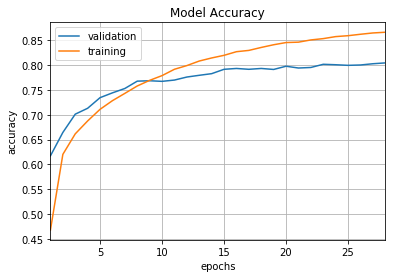

In [26]:
# plot model accuracy
plot_fig(1, model_a, 28)

# Evaluate model

In [28]:
# load weights from file (can call without model.fit)
model.load_weights("cifr_cnn.h5")

scores = model.evaluate(x_test_norm, y_test_one_hot)

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

10000/10000 [==============================] - 3s 320us/step
Loss: 0.606
Accuracy: 0.805


In [32]:
# make test predictions
y_pred_test = model.predict_proba(x_test_norm)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

confusion_matrix(y_test, y_pred_test_classes)

array([[827,  10,  37,  15,   9,   3,   9,   5,  60,  25],
       [ 15, 881,   2,   1,   0,   2,   5,   0,  20,  74],
       [ 54,   2, 719,  40,  58,  46,  45,  19,  13,   4],
       [ 23,   8,  63, 615,  48, 154,  54,  10,   9,  16],
       [ 16,   1,  55,  41, 773,  29,  37,  32,  12,   4],
       [  6,   3,  51, 103,  35, 753,  14,  29,   0,   6],
       [  5,   4,  48,  46,  21,  14, 853,   3,   4,   2],
       [ 14,   1,  40,  26,  42,  48,   3, 819,   4,   3],
       [ 40,  13,   4,   6,   1,   4,   5,   3, 912,  12],
       [ 19,  39,   4,   8,   3,   1,   4,   3,  24, 895]])

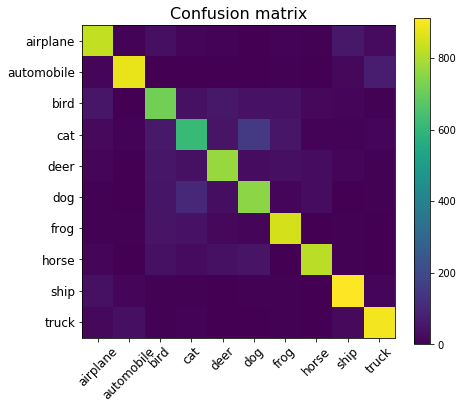

('Test accuracy:', 0.8047)


In [33]:
# confusion matrix and accuracy
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

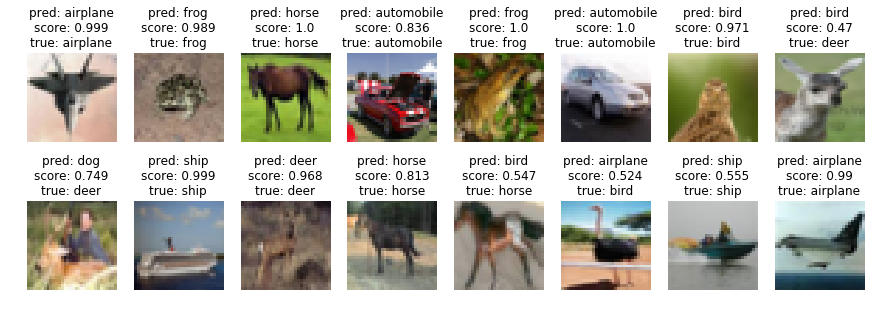

In [34]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()